# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Этапы исследования:
- предобрабтка данных - данные будут очищены от пустых значений и вбросов, приведены к корректному типу;
- кодирование категориальных признаков, а также масштабирование количественных;
- разделение данных на выборки;
- построение моделей: Дерево решений, Случайный лес, а также моделей градиентного бустинга с помощью Catboost и lightgbm;
- оценка метрики качества (RMSE);
- оценка времени, затраченного моделью на обучение и предсказание;
- сравнение моделей и выбор оптимальной;
- проверка выбранной модели на тестовой выборке;
- выводы.

## Подготовка данных

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time
import warnings
warnings.filterwarnings('ignore')

### 1.1 Изучение общей информации

In [42]:
df = pd.read_csv('/datasets/autos.csv', index_col=[0], parse_dates=[0])
    
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354369 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  DateCreated        354369 non-null  object
 12  NumberOfPictures   354369 non-null  int64 
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(7), object(8)
memory usag

In [44]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [45]:
df.duplicated().sum()

89

Типы данных в столбцах соответствуют содержимому. В стоблцах с типом автомобиля, коробкой передач, моделью, типом топлива и сведениями о ремонте имеются пропуски. Помимо характеристик автомобиля, датафрейм содержит данные о пользователе (индекс, дата загрузки объявления). Названия столбцов содержат заглавные буквы, однако поскольку многие названия составные, приведение к нижнему регистру сделает их трудно читаемыми.

### 1.2 Обработка дубликатов и пропусков

В данных имеются дубликаты, пропуски, а также сведения, очевидно не влияющие на цену. В частности, это личные данные - почтовый индекс владельца, дата последней активности пользователя, дата скачивания анкеты. Удалим эти признаки. Для определения возраста автомобиля достаточно столбца "год регистрации автомобиля", поэтому также удалим столбец "месяц регистрации автомобиля". Кроме того, удалим дубликаты

In [46]:
# Удаляем явные дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

Сами по себе столбцы с датами не очень информативны, однако на их основе можно составить столбец со сведениями о том, сколько дней автомобиль был в продаже. Для этого переводим столбцы "Дата создания объявления" и "Дата последней активности" в формат datetime, получаем разницу между этими столбцами и помещаем ее в отдельный столбец "дни в продаже".

In [47]:
# Меняем тип данных
df[['DateCreated', 'LastSeen']] = df[['DateCreated', 'LastSeen']].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')
# Создаем столбец с разницей 
df['DaysInSale'] = df['LastSeen'] - df['DateCreated']
# Для удобства оставим в столбце только дни в продаже, и переведем его тип в целочисленный
df['DaysInSale'] = df['DaysInSale'].astype('timedelta64[D]').astype('int')
# Посмотрим, корректно ли добавился столбец
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysInSale
DateCrawled,,,,,,,,,,,,,,,,
2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,14
2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,14
2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,22
2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,0
2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,6


In [48]:

# Удалям персональные данные и колонки с датами
df = df.drop(columns=['DateCreated','RegistrationMonth', 'PostalCode','LastSeen'])

Изучим и обработаем пропуски в данных

In [49]:
# Оцениваем количество пропусков 
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19832
Power                   0
Model               19705
Kilometer               0
FuelType            32892
Brand                   0
Repaired            71149
NumberOfPictures        0
DaysInSale              0
dtype: int64

In [50]:
# Посмотрим, какие значения содержатся в столбцах, в которых есть пропуски
columns = ['VehicleType', 'Gearbox','FuelType', 'Repaired']
for i in columns:
    print(df[i].value_counts())
    print('_________________')


sedan          91428
small          79812
wagon          65146
bus            28772
convertible    20199
coupe          16153
suv            11992
other           3288
Name: VehicleType, dtype: int64
_________________
manual    268177
auto       66271
Name: Gearbox, dtype: int64
_________________
petrol      216300
gasoline     98689
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
_________________
no     247081
yes     36050
Name: Repaired, dtype: int64
_________________


Пропуски обработаем следующим образом: 
-  "NotRepaired" пользователи могли игнорировать и не заполнять в случае, если автомобиль не был в ремонте. Заполним пустые значения как 'no';
- столбцы с типом коробки передач и топливом заполним самыми распространенными типами - механическая и бензин соответственно;
-  пропуски с столбцах с типом автомобиля и моделью автомобиля замолним на значение "неизвестен" (пропусков больше 10%, при удалении потеряется большая часть данных, что нежелательно)

In [51]:
df['Repaired'] = df['Repaired'].fillna('no')
df['Gearbox'] = df['Gearbox'].fillna('manual')
df['FuelType']= df['FuelType'].fillna('petrol')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')

# Убедимся, что обработка пропусков проведена корректно
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
NumberOfPictures    0
DaysInSale          0
dtype: int64

Пропуски обработаны

### 1.3 Обработка аномальных значений

In [52]:
df.describe(percentiles=[.01, .03, .05, .25, .5, .75, .99])

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,DaysInSale
count,354280.000000,354280.000000,354280.000000,354280.000000,354280.0,354280.000000
mean,4416.458541,2004.234859,110.090256,128211.090098,0.0,8.677916
std,4514.138905,90.239242,189.872001,37906.417793,0.0,8.639700
min,0.000000,1000.000000,0.000000,5000.000000,0.0,0.000000
1%,0.000000,1980.000000,0.000000,5000.000000,0.0,0.000000
3%,0.000000,1990.000000,0.000000,20000.000000,0.0,0.000000
5%,200.000000,1992.000000,0.000000,40000.000000,0.0,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0,2.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0,13.000000


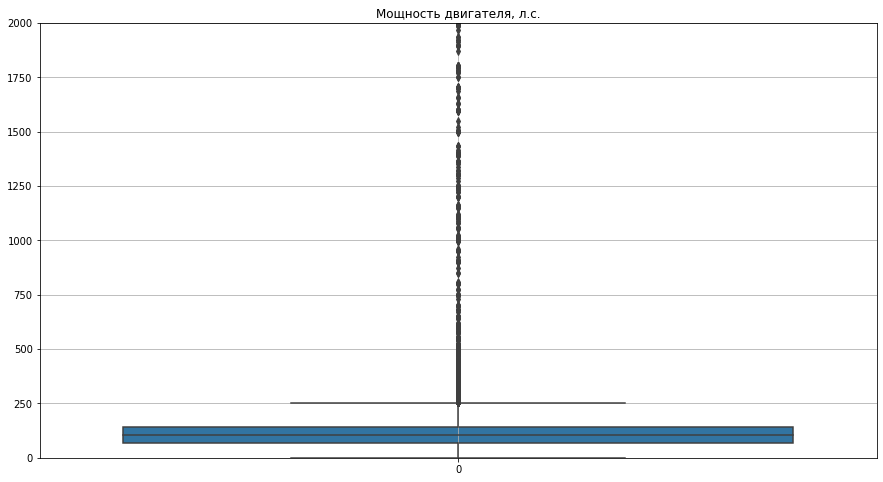

In [53]:
# Построим диаграмму размаха для мощности двигателя
plt.figure(figsize=(15, 8))
sns.boxplot(data=df['Power'])
plt.title('Мощность двигателя, л.с.')
plt.grid(True)
plt.ylim(0, 2000)
plt.show()

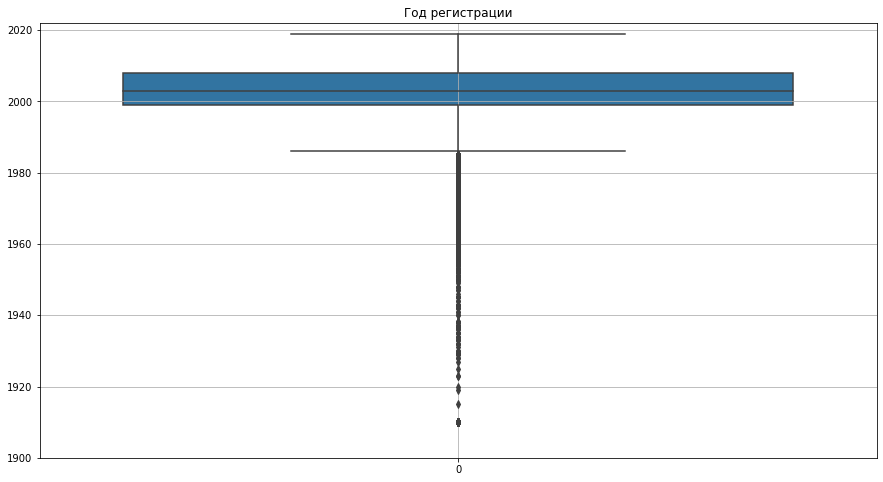

In [54]:
# Построим диаграмму размаха для года регистрации
plt.figure(figsize=(15, 8))
sns.boxplot(data=df['RegistrationYear'])
plt.title('Год регистрации')
plt.grid(True)
plt.ylim(1900, 2022)
plt.show()

В данных имеются вбросы - нулевые значения мощности и цены, также есть аномально высокие значение мощности в тысячи лошадиных сил, не достижимые для автомобильных двигателей. Кроме того, имеются автомобили начала прошлого века, что может как быть вбросом, так и раритетным авто. 

- Судя по объявлениям в Интернете, за автомобиль, проданный на металлолом, можно выручить от 15000 рублей (около 187 евро) то есть продавать автомобиль (средним весом от 1 до 1,5 тонн) дешевле хотя бы 200 евро даже на запчасти не выглядит логичным. Владельцам проще и выгоднее было бы продать такие авто как металлолом. Поэтому отбросим значения цены ниже 200 евро;
- Кроме того, вряд ли старинные редкие раритетные автомобили продаются на общих площадках, а не на специализированных. Скорее всего, это вбросы. Чтобы удалить вбросы и оставить только просто старые автомобили, возьмем объявления с годом автомобиля не ниже 1980. Тем более модели в дальшейнем придется работать с обычными авто, которых продается несоизмеримо больше;
- Также удалим значения мощности выше 600 л.с. (с учетом самых мощных спорткаров). Кроме того, удаляем совсем низкие значени мощности ниже 9 (мощность самой маленькой малолитражки в мире по данным сайта cars.ru);
- Кроме того, есть зависшие объявления, которые в продаже несколько лет. Удалим эти объявления как вбросы. 99 процентов объявлений попадают в месячный интервал, отбросим остальное. 

In [55]:
df = df[(df['Price']>=200)\
       &(df['RegistrationYear']>=1970)&(df['RegistrationYear']<2017)\
       &(df['Power'] <=1600)&(df['Power']>=9)\
       &(df['DaysInSale']<=31)].reset_index()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289996 entries, 0 to 289995
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       289996 non-null  datetime64[ns]
 1   Price             289996 non-null  int64         
 2   VehicleType       289996 non-null  object        
 3   RegistrationYear  289996 non-null  int64         
 4   Gearbox           289996 non-null  object        
 5   Power             289996 non-null  int64         
 6   Model             289996 non-null  object        
 7   Kilometer         289996 non-null  int64         
 8   FuelType          289996 non-null  object        
 9   Brand             289996 non-null  object        
 10  Repaired          289996 non-null  object        
 11  NumberOfPictures  289996 non-null  int64         
 12  DaysInSale        289996 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 28.

### 1.4 Подготовка признаков для обучени моделей

In [57]:
# выделим признаки, на которых будет обучаться модель, и целевой признак

features = df.drop(['Price'], axis=1) 
target = df['Price'] # целевой признак 

# Разделим данные на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split\
(features, target, test_size=0.25, random_state=12345)

feature_names = features_train.columns.values.tolist ()
# выводим размеры полученных выборок
print('Размер обучающей выборки', len(features_train))
print('Размер тестовой выборки', len(features_test))

Размер обучающей выборки 217497
Размер тестовой выборки 72499


Среди признаков имеются категориальные, а количественные признаки имеют разный масштаб. Отмасштабируем численные признаки с помощью StandartScaler. Для кодирования категориальных будем использовать OrdinalEncoder(). 

In [58]:
# Выделяем категориальные признаки
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
# Выделяем признаки, которые необходимо масштабировать
numeric= ['RegistrationYear','Power','Kilometer','NumberOfPictures']

# Создаем преобразователь 
col_transformer = ColumnTransformer(transformers=[
                                   ('oe', OrdinalEncoder(), category), ('ss', StandardScaler(), numeric)])

# Обучаем преобразователь на тренировочной выборке
col_transformer.fit(features_train)

# Преобразовываем обучающую выборку
features_train = pd.DataFrame(col_transformer.transform(features_train), index=features_train.index)
# Преобразовываем тестовую выборку
features_test = pd.DataFrame(col_transformer.transform(features_test), index=features_test.index)


In [59]:
features_train.head()
                                       

,0,1,2,3,4,5,6,7,8,9
198207,5.0,1.0,128.0,6.0,10.0,0.0,0.813101,-0.892096,-1.053229,0.0
224965,4.0,1.0,11.0,2.0,2.0,0.0,0.006823,0.477856,0.589727,0.0
16850,5.0,1.0,120.0,6.0,30.0,0.0,0.329334,-0.790618,0.589727,0.0
224849,5.0,1.0,166.0,6.0,6.0,1.0,0.974356,-0.790618,-2.696185,0.0
39324,5.0,1.0,101.0,6.0,31.0,0.0,0.329334,-1.145791,-1.053229,0.0


In [60]:
features_test.head()

,0,1,2,3,4,5,6,7,8,9
253768,5.0,1.0,101.0,6.0,31.0,0.0,0.006823,-0.350880,0.589727,0.0
220813,4.0,1.0,166.0,2.0,35.0,0.0,0.813101,-0.029533,-0.779403,0.0
45293,4.0,1.0,116.0,6.0,38.0,0.0,-0.960711,-0.350880,0.589727,0.0
265548,4.0,1.0,65.0,6.0,22.0,0.0,-0.476944,0.055032,0.589727,0.0
176173,4.0,0.0,166.0,6.0,10.0,0.0,-0.960711,0.427117,0.589727,0.0


В рамках предобработки данных:
- заполнены пропуски в данных. Там, где это возможно, пропуски заполнены самым распространенным значением, в других случаях пропуски заполнены значением "неизвестно" (во избежание потери большого числа данных);
- удалены аномальные значения цены, года выпуска и мощности;
- удалены столбцы с личными даннными, не влияющими на целевую переменную (почтовый индекс, дата создания, дата загрузки, дата последней активности, месяц регистрации автомобиля);
- в результате датафрейм сократился на 15%;
- выделены целевой и обучающие признаки;
- данные разделены на обучающую и тестовую выборки;
- категориальные признаки закодированы с помощью OneHotEncoder();
- количественные признаки отмасштабированы.

## 2 Обучение моделей

Построим и обучим несколько моделей - дерево решений, случайный лес, модели градиентного бустинга с помощью LightGBM и CatBoost. 

### 2.1 Дерево решений

In [61]:

# Инициируем модель Дерево решений
model_dt=DecisionTreeRegressor(random_state=12345)
parameters= {'max_depth':range(1,10)}                                    
grid_dt=GridSearchCV(model_dt,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                     cv=5) 

# Обучаем модель
# start = time.time()
model_dt_final = grid_dt.fit(features_train, target_train)
#end = time.time()
#learn_time_dt = round(end-start, 4)

# Делаем предсказания
start = time.time()
model_dt_final.predict(features_train)
end = time.time()
predict_time_dt=round(end-start,2)
print('Время предсказания модели Дерево решений (секунды):', predict_time_dt)

# Считаем RMSE 
dt_rmse = ((model_dt_final.best_score_)*(-1))**0.5
print('Лучшее значение глубины для Дерева решений:', model_dt_final.best_params_)
print('RMSE модели Дерево решений:', dt_rmse)


Время предсказания модели Дерево решений (секунды): 0.03
Лучшее значение глубины для Дерева решений: {'max_depth': 9}
RMSE модели Дерево решений: 2008.7840402758502


In [62]:
# Отдельно замерим, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_dt_final = DecisionTreeRegressor(random_state=12345, max_depth=9)
model_dt_final.fit(features_train, target_train)
end = time.time()
learn_time_dt = round(end-start, 4)
print('Время обучения модели Дерево решений с лучшими гиперпараметрами (секунды):', learn_time_dt)

Время обучения модели Дерево решений с лучшими гиперпараметрами (секунды): 0.5769


### 2.2 Случайный лес

In [63]:
# Инициируем модель 
model_rf = RandomForestRegressor(random_state=12345)
parameters= {'max_depth':(10,50),
             'n_estimators':range(10, 50, 10)}                                 
grid_rf=GridSearchCV(model_rf,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                     cv=5) 

# Обучаем модель
model_rf_final = grid_rf.fit(features_train, target_train)

# Делаем предсказания
start = time.time()
model_rf_final.predict(features_train)
end = time.time()
predict_time_rf=round(end-start,2)
print('Время предсказания модели  Случайный лес (секунды):', predict_time_rf)

# Считаем RMSE 
rf_rmse = ((model_rf_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для Случайного леса:', model_rf_final.best_params_)
print('RMSE модели Случайный лес:', rf_rmse)


Время предсказания модели  Случайный лес (секунды): 3.25
Лучшее значение параметров для Случайного леса: {'max_depth': 50, 'n_estimators': 40}
RMSE модели Случайный лес: 1594.551448481221


In [64]:
# Отдельно замерим, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_rf_final = RandomForestRegressor(random_state=12345, max_depth=50, n_estimators=40)
model_rf_final.fit(features_train, target_train)
end = time.time()
learn_time_rf = round(end-start, 5)
print('Время обучения модели Случайный лес с лучшими гиперпараметрами (секунды):', learn_time_rf)

Время обучения модели Случайный лес с лучшими гиперпараметрами (секунды): 22.45425


### 2.3  LightGBM

In [65]:
model_lgb = lgb.LGBMRegressor()
parameters = {'max_depth':[5, 10, 15]}
             #'learning_rate':[0.01, 0.1]}

grid_lgbm = GridSearchCV(model_lgb,param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=3)                        
                          
# Обучаем модель

model_lgb_final = grid_lgbm.fit(features_train, target_train)

# Делаем предсказания
start = time.time()
model_lgb_final.predict(features_train)
end = time.time()
predict_time_lgbm = round(end-start,2)
print('Время предсказания модели   LightGBM (секунды):', predict_time_lgbm)

# Считаем RMSE 
lgbm_rmse = ((model_lgb_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для  LightGBM:', model_lgb_final.best_params_)
print('RMSE модели LightGBM:', lgbm_rmse)

Время предсказания модели   LightGBM (секунды): 1.6
Лучшее значение параметров для  LightGBM: {'max_depth': 15}
RMSE модели LightGBM: 1675.1653505296624


In [66]:
# Отдельно замерим, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_lgb_final = lgb.LGBMRegressor(max_depth=15)
model_lgb_final.fit(features_train, target_train)
end = time.time()
learn_time_lgbm = round(end-start, 4)
print('Время обучения модели LightGBM с лучшими гиперпараметрами (секунды):', learn_time_lgbm)

Время обучения модели LightGBM с лучшими гиперпараметрами (секунды): 345.4867


### 2.4 CatBoost

In [67]:
model_cat= CatBoostRegressor(loss_function='RMSE', iterations=30, random_state=12345)
parameters = {'max_depth':[5, 10, 15]}
            # 'learning_rate':[0.01, 0.1, 0.15]}

# Встроенный подбор параметров самого catboost считал дольше при таком же качестве, оставила GridSearchCV
grid_cat= GridSearchCV(model_cat,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                    cv=5) 
# Обучаем модель
model_cat_final = grid_cat.fit(features_train, target_train)

# Делаем предсказания
start = time.time()
model_cat_final.predict(features_train)
end = time.time()
predict_time_cat = round(end-start,2)
print('Время предсказания модели   CatBoost (секунды):', predict_time_cat)

# Считаем RMSE 
cat_rmse = ((model_cat_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для  CatBoost:', model_cat_final.best_params_)
print('RMSE модели CatBoost:', cat_rmse)


Learning rate set to 0.5
0:	learn: 3319.0745770	total: 72ms	remaining: 2.09s
29:	learn: 1430.4565091	total: 18.2s	remaining: 0us
Время предсказания модели   CatBoost (секунды): 0.08
Лучшее значение параметров для  CatBoost: {'max_depth': 15}
RMSE модели CatBoost: 1605.2909325949008


In [68]:
# Отдельно замерим, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_cat_final = CatBoostRegressor(loss_function='RMSE', iterations=30, random_state=12345,\
                                    learning_rate=0.15, max_depth=15)
model_cat_final.fit(features_train, target_train)
end = time.time()
learn_time_cat = round(end-start, 5)
print('Время обучения модели CatBoost с лучшими гиперпараметрами (секунды):', learn_time_cat)

0:	learn: 4073.4385766	total: 646ms	remaining: 18.7s
29:	learn: 1613.7309615	total: 18.1s	remaining: 0us
Время обучения модели CatBoost с лучшими гиперпараметрами (секунды): 19.02816


Выводы: обучены четыре модели, наилучшее значение точности показала модель Случайный лес

## 3. Анализ моделей

### 3.1 Сравнение моделей

In [71]:
# Собираем показатели моделей и время их обучения и предсказаний
final_df = pd.DataFrame({'RMSE':[dt_rmse, rf_rmse, lgbm_rmse, cat_rmse],\
                         'Время обучения':[learn_time_dt, learn_time_rf, learn_time_lgbm, learn_time_cat],\
                         'Время предсказания':[predict_time_dt, predict_time_rf,\
                                               predict_time_lgbm, predict_time_cat]},\
                         index=['Дерево решений','Случайный лес','LightGBM', 'CatBoost'])
final_df

,RMSE,Время обучения,Время предсказания
Дерево решений,2008.784040,0.57690,0.03
Случайный лес,1548.846971,22.45425,3.25
LightGBM,1675.165351,345.48670,1.60
CatBoost,1605.290933,19.02816,0.08


В результате обучения четырех моделей:
- наивысшую скорость работы показала модель Дерево решений, однако низкая точность не позволет назвать ее оптимальной;
- точность модели LightGBM выше, однако и скорость обучения у нее максимальная;
- наилучшие показатели у модели Случайный лес и CatBoost, при этом модель Случайный лес достигает бОльшей точности.

По итогам сравнения предлагается остановится на модели Случайный лес, как на самой точной.

### 3.2 Проверка лушей модели на тестовой выборке

Проверим выбранную модель на тестовой выборке

In [72]:
model_rf = RandomForestRegressor(random_state=12345, max_depth=50, n_estimators=40)
model_rf.fit(features_train, target_train)
predictions_test = model_rf.predict(features_test)

rf_rmse = mean_squared_error(target_test, predictions_test) ** .5
print('RMSE модели Случайный лес:', rf_rmse)

RMSE модели Случайный лес: 1548.846971469874


Качество предсказаний на тестовой выборке не ниже, чем на тренировочной

Выводы:
- В ходе исследования заполнены пропуски в данных. Там, где это возможно, пропуски заполнены самым распространенным значением, в других случаях пропуски заполнены значением "неизвестно" (во избежание потери большого числа данных);
- в данные добавлен столбец с числом дней в продаже;
- в данных присутствовали аномальные значения цены, года выпуска и мощности, а также аномальные значения длительности размещения объвления. Аномалии удалены;
- удалены столбцы с личными даннными, не влияющими на целевую переменную (почтовый индекс, дата создания, дата загрузки, дата последней активности, месяц регистрации автомобиля);
- в результате датафрейм сократился на 15%;
- выделены целевой и обучающие признаки;
- данные разделены на обучающую и тестовую выборки;
- категориальные признаки закодированы с помощью OneHotEncoder();
- количественные признаки отмасштабированы;
- построены модели Дерево решений, случаный лес, LightGBM и Catboost.
- по результатам в качестве оптимальной отобрана модель Случайный лес;
- выбранная модель проверена на тестовой выборке.
